# Testing package `Whirl2d`

In [336]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body

In [337]:
Npts = 100
rad = 0.5
xcent = [-1.0,0.0]
ang = 0.0
b = Bodies.Circle(Npts,rad,xcent,ang)

Body: number of points = 100, reference point = (-1.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]


### Create a domain with this body in it

In [338]:
xmin = [-2.0,-2.0]
xmax = [3.0,2.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b)

Domain: xmin = [-2.0, -2.0], xmax = [3.0, 2.0]
number of bodies = 1
Body: number of points = 100, reference point = (-1.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [343]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-2.0, -2.0], xmax = [3.0, 2.0]
number of bodies = 1
Body: number of points = 100, reference point = (-1.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (250,200), Δx = 0.02, xmin = [-2.0, -2.0], xmax = [3.0, 2.0]



### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [344]:
Re = 200
α = 0.25
@time ops = NavierStokes.set_operators_body!(dom,α);

 28.302646 seconds (185.59 M allocations: 12.507 GiB, 9.37% gc time)


### Set the time parameters

In [345]:
Δt = α*Δx^2*Re
p = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

Whirl2d.TimeMarching.TimeParams(0.02, Whirl2d.TimeMarching.RKparams(3, [0.5, 1.0, 1.0], Array{Float64,N} where N[[0.5], [0.57735, 0.42265], [0.788675, -0.57735, 0.788675]]))

### Create an initial solution structure

In [346]:
s = NavierStokes.BodySoln(dom)
A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

In [347]:
s = TimeMarching.ifherk!(s,p,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)

Solution: t = 0.02


In [366]:
@time for i = 1:10
    s = TimeMarching.ifherk!(s,p,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s

Solution: t = 1.0200000000000005


  7.304551 seconds (45.86 M allocations: 3.265 GiB, 15.04% gc time)


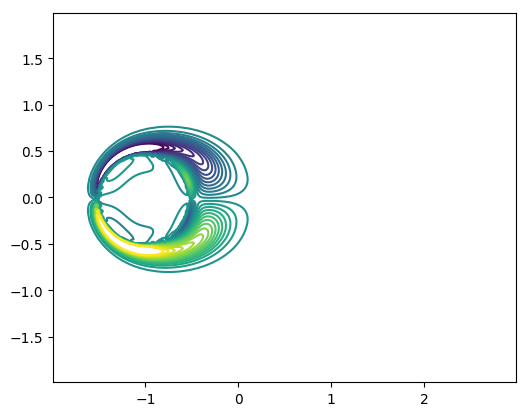

(-1.99, 2.99, -1.99, 1.9900000000000002)

In [367]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
axis("scaled")

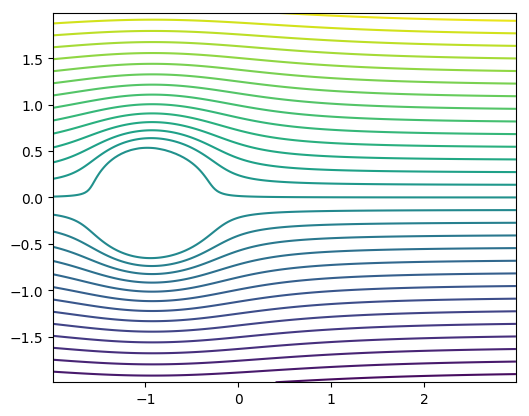

(-1.99, 2.99, -1.99, 1.9900000000000002)

In [364]:
s.ψ = -Grids.L⁻¹(dom.grid,s.u)
contour(x,y,s.ψ[dom.grid.cellint[1],dom.grid.cellint[2]]*Δx+y,linspace(-2,2,31))
axis("scaled")

Plot the C<sup>T</sup> E<sub>y</sub><sup>T</sup> operator

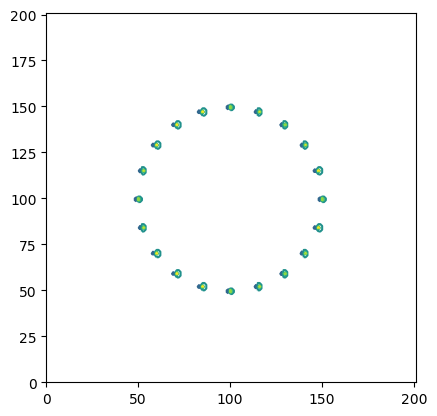

(0.0, 201.0, 0.0, 201.0)

In [190]:
contour(reshape(dom.ECᵀ[1]*ones(dom.nbodypts),size(dom.grid.cell)))
axis("scaled")

In [15]:
# Create a "grid unit vector": a bunch of cell data with zeros everywhere except at one point.
# This is useful for visualizing the LGF and the integrating factor
wunit = zeros(dom.grid.cell);
wunit[40,40] = 1.0;

In [192]:
# This is the discrete convolution of the integrating factor with the grid unit vector
# The result is just the integrating factor field, but shifted to the center specified
# in the grid unit vector.
@time s = Grids.Q(dom.grid,wunit);

  0.037541 seconds (264.80 k allocations: 14.863 MiB, 13.88% gc time)


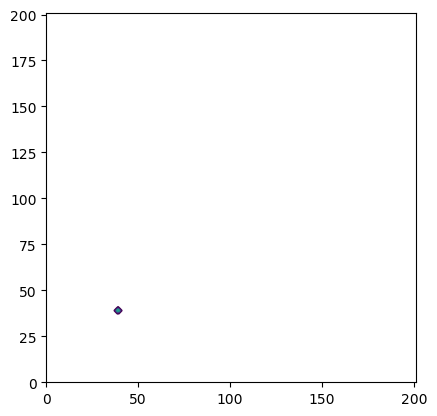

(0.0, 201.0, 0.0, 201.0)

In [193]:
# plot this
contour(s,linspace(0.01,1,31))
axis("scaled")

In [194]:
# This is the discrete convolution of the LGF with the grid unit vector
@time s = Grids.L⁻¹(dom.grid,wunit);

  0.022773 seconds (245.24 k allocations: 13.999 MiB)


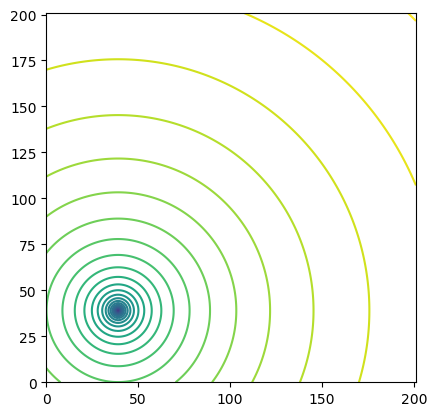

(0.0, 201.0, 0.0, 201.0)

In [195]:
# plot this
contour(s,31)
axis("scaled")